In [1]:
import requests
import json
import numpy as np
import pandas as pd
import scipy.stats
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# API host requests a descriptibe user User-Agent w/ usecase description and contact (discord in this case)
user_agent = "Exploring the API in a jupyter notebook in pursuit of developing daily report generator to support flipping - @Nadr0j#5823"

# Goals
The wikipedia for the MMORPG Runescape has just made real-time pricing data available via their API. My goal is to explore the available information and to develope some preliminary functions for aggregating data and understanding the movement of in-game item prices, their distributions, and profit potential for the buying and selling of these items.

# Util function
Many json responses come in form 
  

    [{field1: value11,
     field2: value12,
     ...
     },
     {field1: valuen1,
      field2: valuen2,
      ...
     }]

This function will allow us to map this structure into a structure which can be turned into a pandas.DataFrame

In [3]:
def json_to_dict(json_response):
    result = collections.defaultdict(list)
    for datum in json_response:
        for k, v in datum.items():
            result[k].append(v)

    result = dict(result)
    return result

# Generate limit table

In [4]:
# Gives list of objects w/ name, id, examine, members, lowalch, highalch, ge buy limit, icon name
mapping_endpoint = "https://prices.runescape.wiki/api/v1/osrs/mapping"

In [5]:
r = requests.get(mapping_endpoint, headers={"User-Agent": user_agent})

In [6]:
js = json.loads(r.text)

In [7]:
js[0]

{'examine': 'Fabulously ancient mage protection enchanted in the 3rd Age.',
 'highalch': 30300,
 'icon': '3rd age amulet.png',
 'id': 10344,
 'limit': 8,
 'lowalch': 20200,
 'members': True,
 'name': '3rd age amulet',
 'value': 50500}

### This data requires a special if-else statement to prevent ragged-list issues so we manually parse

In [8]:
ids = []
names = []
limits = []

for item in js:
    id = item['id']
    name = item['name']
    if 'limit' in item:
        limit = item['limit']
    else:
        continue

    ids.append(id)
    names.append(name)
    limits.append(limit)

limit_table = pd.DataFrame({
    'id': ids,
    'name': names,
    'limit': limits 
})

limit_table.set_index(['id'], inplace=True)
limit_table

,name,limit
id,,
10344,3rd age amulet,8
20011,3rd age axe,40
12424,3rd age bow,8
12437,3rd age cloak,8
23345,3rd age druidic cloak,8
...,...,...
4812,Zogre bones,3000
19912,Zombie head (Treasure Trails),4
12938,Zul-andra teleport,10000


# Get 24hr data on margins, volume

In [9]:
def get_daily_metrics(item_id, user_agent, period='5m'):
    '''
    Params:
        item_id:int 
            The unique id corresponding to an in-game item
        user_agent:str
            The API User-Agent
        period:str 
            An API parameter either '5m', '1h', '6h', or '24hr'. This determines
            the time period over which to populate the returned dataframe with
            pricing information for item corresponding to item_id
    Returns:
        df:pandas.DataFrame
            Dataframe with schema (timestamp, avgHighPrice, avgLowPrice,
                                   highPriceVolume, lowPriceVolume)
    '''

    day_endpoint = "https://prices.runescape.wiki/api/v1/osrs/timeseries"
    payload = {'id': item_id, 'timestep': period}

    r = requests.get(day_endpoint, headers={"User-Agent": user_agent}, params=payload)
    data = json.loads(r.text)['data']
    data_dict = json_to_dict(data)
    
    df = pd.DataFrame(data_dict)

    return df

In [10]:
limit_table.loc[4736]

name     Karil's leathertop
limit                    15
Name: 4736, dtype: object

In [11]:
df = get_daily_metrics(4736, user_agent)
df.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume
0,1644946200,3335511.0,NaN,1,0
1,1644946500,3329674.0,3271624.0,1,2
2,1644946800,3323846.0,3275447.0,1,6
3,1644947100,3322391.0,3277358.0,4,1
4,1644947400,3321906.0,3276904.0,3,3


In [12]:
num_NaN = df.shape[0] - df.dropna().shape[0]
print(f'The API call for item id 4736 had {num_NaN} NaN rows using the "5m" api param')

The API call for item id 4736 had 95 NaN rows using the "5m" api param


The high na rate is acceptable since we have an extremely high data resolution using the '5m' api parameter. However, if the NA rate were this high for a '24hr' api call too much data might be missing for meaningful inference to be performed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f690d9f0b90>,
      dtype=object)

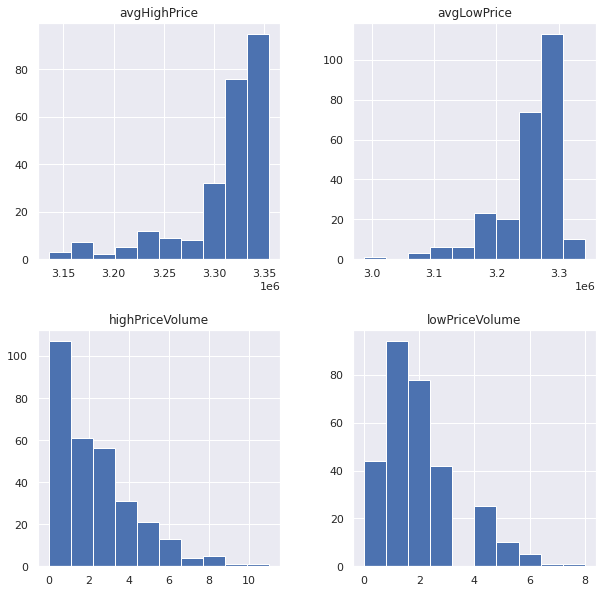

In [13]:
df[['avgHighPrice', 'avgLowPrice', 'highPriceVolume', 'lowPriceVolume']].hist(figsize = (10, 10))

# Define code to produce margin confidence intervals

In [14]:
def get_margin_confidence_interval(margin_series, confidence=0.95):
    # margin_series is a pd data series
    # Returns numpy array of values
    deg_freedom = len(margin_series) - 1
    lower_conf, upper_conf = scipy.stats.t.interval(confidence, deg_freedom,
                                                    loc=margin_series.mean(), 
                                                    scale=margin_series.std())
    return lower_conf, upper_conf

# Define a function to summarize daily metrics

In [15]:
def get_metric_summaries(item_id, user_agent, window=60, return_pre_avg=False):
    '''
    Returns a DataFrame of summary statistics for item_id over the last
    window number of 5-minute time chunks.

    Params:
        item_id:int 
            The unique id corresponding to an in-game item
        user_agent:str
            The API User-Agent
        window:int (optional) (default=60)
            The number of past-minutes from which to gather pricing data.
            ex. window=60 would be the pricing data from last hour
        return_pre_avg:bool (optional) (default=False)
            If False (default) then function returns df of summary statistics
            If True then function returns raw data before computation of summary stats
    
    Returns:
        pandas.DataFrame (see Param return_pre_avg description)
    '''

    last_n_rows = min(window // 5, 300) # Divide window into 5 minute chunks :: 300 is max
    df = get_daily_metrics(item_id, user_agent)
    df = df.iloc[-last_n_rows:]

    # Calculate how much data in lost by dropping na
    pre_drop_num_rows = df.shape[0]
    df = df.dropna()
    post_drop_num_rows = df.shape[0]

    if df.shape[0] < 2: # Not enough trades for this item exist in window
        return -1 # Other functions toss results when encountering -1

    # Calculate margin
    # * .99 calculates the 1% selling tax
    df['margin'] = df['avgHighPrice'] * .99 - df['avgLowPrice']
    # Calculate pressure (tendency for +/- in margin)
    df['pressure'] = df['highPriceVolume'] - df['lowPriceVolume']
    
    if return_pre_avg: # For diagnostics and other analyses
        return df

    # Add margin confidence interval
    margin_confidence_interval_low, margin_confidence_interval_high = get_margin_confidence_interval(df['margin'])
    # Records how much data was lost
    df['resolution'] = post_drop_num_rows / pre_drop_num_rows
    # Average data over columns
    df = df.mean(axis=0)
    # Drop useless data
    df = df.drop(['timestamp', 'avgHighPrice', 'avgLowPrice', 'highPriceVolume', 'lowPriceVolume'])
    # Add margin confidence val
    df['lowest_margin_95%_conf'] = margin_confidence_interval_low
    df['highest_margin_95%_conf'] = margin_confidence_interval_high

    # Relabel margin to be avg_margin
    df.rename({'margin': "avg_margin"}, axis='columns', inplace=True)

    return df

- avg_margin  - The average price between the instant buy and instant sell prices with tax taken into account
- pressure - The average difference between # of high and low price volume trades
- Resolution - The percent of original data recieved (in rows) by API call that had no NaN vals
- lowest/highest_margin_95% conf - the upper and lower bounds of the 95% confidence interval of the true margin 

In [16]:
get_metric_summaries(4151, user_agent, window=360)

avg_margin                 10507.811528
pressure                      -0.430556
resolution                     1.000000
lowest_margin_95%_conf    -11722.722088
highest_margin_95%_conf    32738.345144
dtype: float64

In [17]:
df = get_metric_summaries(4151, user_agent, window=360, return_pre_avg=True)

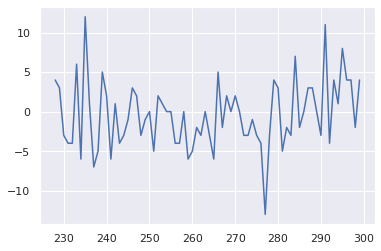

In [18]:
df['pressure'].plot()

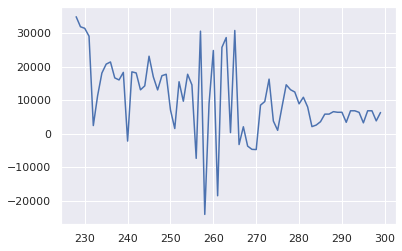

In [19]:
df['margin'].plot()

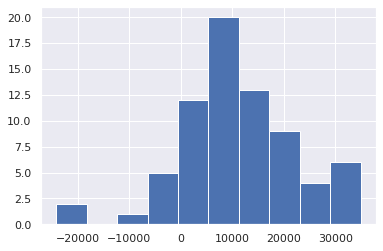

In [20]:
df['margin'].hist()

# Evaluate the efficacy of running_pressure as a predictor of margin movement

In [21]:
def shifted_crosscorr(series1, series2, lag=0):
    df = pd.concat([series1, series2.shift(lag)], axis=1)
    return df.corr().values.tolist()[0][1]

In [22]:
def window_lag_grid_search(series1, series2, max_window=12, max_lag=12):
    # SERIES1 IS THE PREDICTOR
    # SERIES2 IS THE PREDICTED
    max_corr = 0
    best_window = 0
    best_lag = 0

    for window in range(1, max_window):
        for lag in range(1, max_lag):
            series1_rolling = series1.rolling(window).sum() / window
            corr = shifted_crosscorr(series1_rolling, series2, lag=lag)
            if corr > max_corr:
                max_corr = corr
                best_window = window
                best_lag = lag
                
    return max_corr, best_window, best_lag

In [23]:
# Handful of items which have relatively high volume trading
for item_id in [2, 4151, 4585, 554, 21820, 13263, 810, 2481, 21817, 2452, 10476, 569]: 
    df = get_metric_summaries(item_id, user_agent, window=1440, return_pre_avg=True) # 1440 is a days worth of data
    corr, window, lag = window_lag_grid_search(df['pressure'], df['margin'])
    print(f"Item {item_id} has max corr {corr} with window {window} and lag {lag}")

Item 2 has max corr 0.18607015746528605 with window 1 and lag 5
Item 4151 has max corr 0.1346380183941272 with window 1 and lag 11
Item 4585 has max corr 0.14151114248162722 with window 1 and lag 7
Item 554 has max corr 0.14262427696120217 with window 2 and lag 2
Item 21820 has max corr 0.12726138340159213 with window 7 and lag 1
Item 13263 has max corr 0.15349970920554346 with window 4 and lag 6
Item 810 has max corr 0.040306325217402905 with window 1 and lag 7
Item 2481 has max corr 0.24282783539241068 with window 2 and lag 8
Item 21817 has max corr 0.23068487422655562 with window 5 and lag 5
Item 2452 has max corr 0.3311450821740226 with window 10 and lag 1
Item 10476 has max corr 0.24370298969101328 with window 8 and lag 3
Item 569 has max corr 0.21322857322419814 with window 6 and lag 11


This shows the potential to use running pressure as a predictor for margin for specific items, but also shows that this approach probably wont work generally for all items. Should be explored for specific item if a need for pricing prediction arrises.

# Build function which returns 24hr volume

In [24]:
def get_daily_volume(user_agent):
    endpoint = "https://prices.runescape.wiki/api/v1/osrs/24h"
    r = requests.get(endpoint, headers={"User-Agent": user_agent})
    data = json.loads(r.text)['data']
    data_dict = {'id': [], 'volume': []}
    for k, v in data.items():
        data_dict['id'].append(k)
        data_dict['volume'].append(v['highPriceVolume'] + v['lowPriceVolume'])
    df = pd.DataFrame(data_dict)
    df.set_index('id', inplace=True)
    df.index = df.index.map(int)
    return df

In [25]:
volume_table = get_daily_volume(user_agent)
volume_table.head()

,volume
id,
2,21157062
6,353
8,310
10,311
12,297


# Build 24hr liquidity table

We will score each item's liquidity by calculating ` total_global_trade_volume / daily_buy_limit `. This is a measure of how easily one can buy and sell an item.

In [26]:
def get_liquidity_table(limit_table, user_agent):
    '''
    Returns a DataFrame which scores each item with a liquidity score
    meant to measure how easily one can buy and sell an item

    Params:
        limit_table:pandas.DataFrame
            A table with schema (id(index), volume) where id is the
            unique item id and volume is the global trade volume for the 24hr period
        user_agent:str
            User-Agent for API
    
    Returns:
        pandas.DataFrame
        A table with schema (id(index), name, limit, volume, liquidity score)
        where liquidity score is defined as total_global_trade_volume / daily_buy_limit
    '''

    volume_table = get_daily_volume(user_agent)
    liquidity_table = limit_table.join(volume_table, how='left').sort_index()

    # Can purchase 6 limits per day so we multiply by 6
    liquidity_table['liquidity_score'] = liquidity_table['volume'] / liquidity_table['limit'] * 6 
    liquidity_table.dropna(inplace=True)
    liquidity_table = liquidity_table.sort_values(by='liquidity_score', ascending=True)

    return liquidity_table

In [27]:
liquidity_table = get_liquidity_table(limit_table, user_agent)
liquidity_table.head()

,name,limit,volume,liquidity_score
id,,,,
7064,Egg and tomato,13000,1.0,0.000462
2021,Brandy,13000,1.0,0.000462
21926,Dragon bolts (p+),11000,1.0,0.000545
6213,Mahogany pyre logs,11000,1.0,0.000545
6171,Flattened hide,11000,1.0,0.000545


# Define code to generate at a glance statistics

Create function to generate summary statistics at a glance. Combines outputs of previously defined functions

In [28]:
def multiple_metric_summaries(item_ids, liquidity_table, user_agent, window=60):
    '''
    Returns a DataFrame of summary statistics for item_ids over the last
    window number of 5-minute time chunks.

    Params:
        item_ids:list[int]
            List of unique ids corresponding to an in-game items
        user_agent:str
            The API User-Agent
        window:int (optional) (default=60)
            The number of past-minutes from which to gather pricing data.
            ex. window=60 would be the pricing data from last hour
    
    Returns:
        pandas.DataFrame
            Schema of (id(index), avg_margin, pressure, resolution,
                       lowest_margin_95%_conf, highest_margin_95%_conf)
            avg_margin - post-tax average high_price - low_price
            pressure - average high_price_volume - low_price_volume
            resolution - % of data which had no NaN's (and was not dropped)
            lowest/highest_margin_95%_conf - lower/upper bounds of 95% margin conf interval
    '''
    item_dfs = []

    for id in item_ids:
        temp_series = get_metric_summaries(id, user_agent, window=window)

        if temp_series is -1: # No trades for the item exist so no metrics to summarize
            continue

        temp_df = pd.DataFrame(temp_series.values, index=temp_series.index).transpose()
        temp_df.index = [id]
        item_dfs.append(temp_df)

    return pd.concat(item_dfs)


In [29]:
multiple_metric_summaries([2, 809], liquidity_table, user_agent, window=360)

,avg_margin,pressure,resolution,lowest_margin_95%_conf,highest_margin_95%_conf
2,2.245139,26310.472222,1.000000,-1.671100,6.161378
809,2.587193,-1919.561404,0.791667,-0.705309,5.879695


# Make final table.
Combine previous tables to make final summary statistics table

In [30]:
def get_data(item_ids, liquidity_table, user_agent, window=1440):
    multiple_metric_summaries_df = multiple_metric_summaries(item_ids, liquidity_table, user_agent, window=window)
    df = multiple_metric_summaries_df.join(liquidity_table, how='left').sort_index()
    
    return df

In [31]:
cols = ['name', 'volume', 'limit', 'lowest_margin_95%_conf', 'highest_margin_95%_conf', 'avg_margin', 'pressure', 'resolution', 'liquidity_score']

In [32]:
user_agent = "Call to populate table w/ ~24hr margins/volume. - @Nadr0j#5823"

In [33]:
#item_ids = limit_table.index
# NOTE: Makes # API calls equal to number of items in item_ids
item_ids = [2, 4151, 314, 22326, 9075, 4087, 4712]
df = get_data(item_ids, liquidity_table, user_agent, window=1440)
df[cols]

,name,volume,limit,lowest_margin_95%_conf,highest_margin_95%_conf,avg_margin,pressure,resolution,liquidity_score
2,Cannonball,21157062.0,11000,-2.177088,6.021173,1.922042,29330.281690,0.986111,11540.215636
314,Feather,32214044.0,30000,0.053504,1.540676,0.797090,62087.132275,0.656250,6442.808800
4087,Dragon platelegs,11409.0,70,-3344.675452,2055.366498,-644.654477,-33.460251,0.829861,977.914286
4151,Abyssal whip,3223.0,70,-19595.992078,39072.624218,9738.316070,-0.315175,0.892361,276.257143
4712,Ahrim's robetop,967.0,15,-18528.875441,49826.588695,15648.856627,0.579882,0.586806,386.800000
9075,Astral rune,5748933.0,10000,-4.513758,8.467783,1.977012,5279.414938,0.836806,3449.359800
22326,Justiciar faceguard,305.0,8,-229736.834323,252135.583499,11199.374588,-0.094118,0.295139,228.750000


# Conclusion

We have seen how using the real-time pricing API we can use a statistical approach to guide in-game investing decisions.

# Further analysis
The use of confidence intervals to estimate the true margin for any item requires a normal distribution. **Adding skew and excess kurtosis measures for each item would help a viewer evaluate this assumption**. Additionally, adding a visualization component for historical margins would be beneficial for quick assumption verification